<a href="https://colab.research.google.com/github/naiaraAM/ML_project_UT/blob/main/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Set up enviroment


# Download data


In [1]:
import matplotlib.pyplot as plt
import umap.plot
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from lightgbm import  LGBMClassifier

import xgboost as xgb

import seaborn as sns

import pickle

# remove warnings
import warnings

from torch.backends.mkl import verbose

warnings.filterwarnings('ignore')

/home/chispitas/Documents/UT/Machine Learning/Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chispitas/Documents/UT/Machine Learning/Project/venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/chispitas/Documents/UT/Machine Learning/Project/venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  war

In [2]:
!unzip -q playground-series-s4e6.zip -d data
!rm playground-series-s4e6.zip

unzip:  cannot find or open playground-series-s4e6.zip, playground-series-s4e6.zip.zip or playground-series-s4e6.zip.ZIP.
rm: cannot remove 'playground-series-s4e6.zip': No such file or directory


In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(f"The train data has {train_data.shape[0]} rows and {train_data.shape[1]} columns")
print(f"The test data has {test_data.shape[0]} rows and {test_data.shape[1]} columns")

The train data has 76518 rows and 38 columns
The test data has 51012 rows and 37 columns


<font color='red'>Do your code in the cell bellow your name, so we don't have merge issues. We can merge on friday's meeting</font>


# Data Processing

In [4]:
# We will re-use this code in the future
def plot_class_distribution(y, title="Class Distribution"):

    class_counts = y.value_counts()

    class_counts.plot(kind='bar', color=['skyblue', 'orange', 'red'])
    plt.title(title, fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

In [5]:
X, Y = train_data.drop(columns=['id', 'Target']), train_data['Target']
X.shape, Y.shape, train_data.shape

((76518, 36), (76518,), (76518, 38))

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, random_state = 111, test_size = 0.20, stratify=Y)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((61214, 36), (61214,), (15304, 36), (15304,))

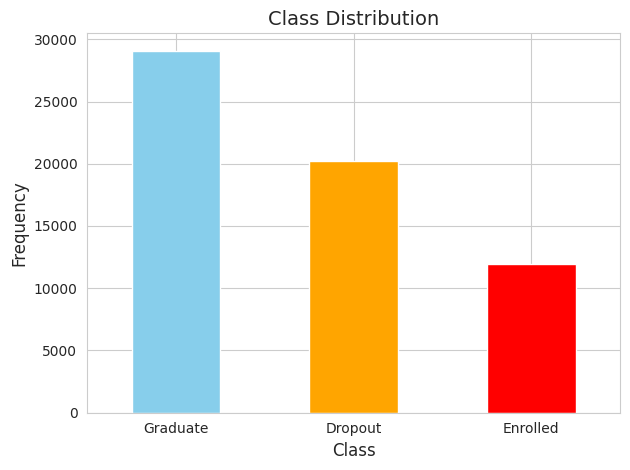

In [7]:
%matplotlib inline

plot_class_distribution(y_train)

In [66]:
# undersample to balance the classes
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_train, y_train)
X_val_balanced, y_val_balanced = rus.fit_resample(X_val, y_val)

In [67]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced) # normalize data
X_val_scaled = scaler.transform(X_val_balanced)
X_test_scaled = scaler.transform(test_data.drop(columns=['id']))

In [68]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_balanced)
y_val_encoded = label_encoder.fit_transform(y_val_balanced)

<Axes: >

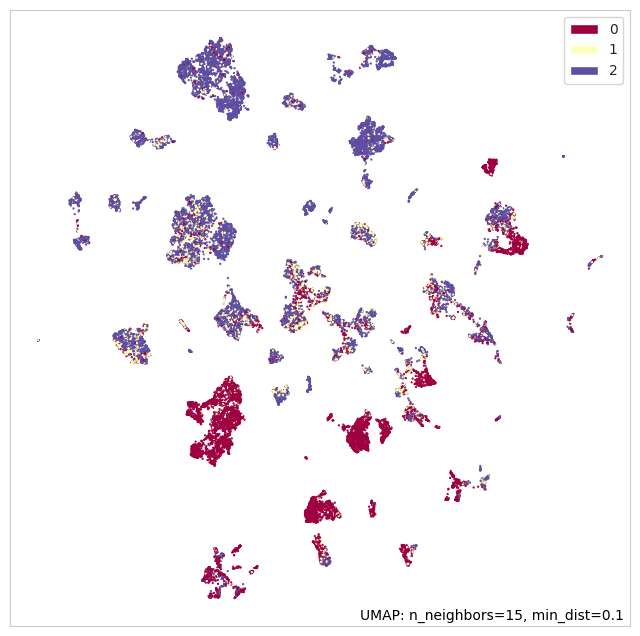

In [59]:
mapper = umap.UMAP().fit(X_scaled)
umap.plot.points(mapper, labels=y_encoded)

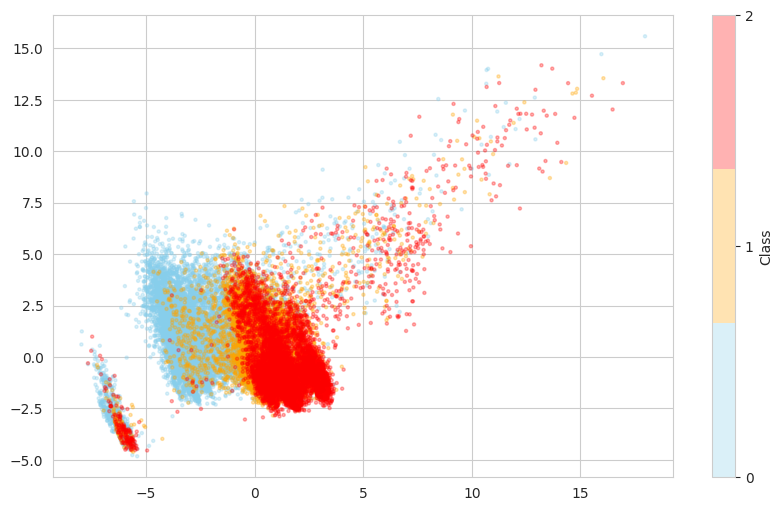

In [69]:
# Define the color map to match the bar plot colors
colors = ['skyblue', 'orange', 'red']
cmap = plt.cm.colors.ListedColormap(colors)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA with the defined color map
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap=cmap, s=5, alpha=0.3)
plt.colorbar(scatter, ticks=[0, 1, 2], label='Class')
plt.show()

# Auxiliar functions

In [12]:
def save_model(model, model_name):
    # use pickle to save model in models folder, create folder if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    with open(f'models/{model_name}.pkl', 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved as 'models/{model_name}.pkl'")

## Naiara


In [70]:
# Define class weights
class_weights = {0: 1, 1: 1, 2: 1}

# Create sample weights based on class weights
sample_weight = [class_weights[label] for label in y_encoded]

# Initialize the HistGradientBoosting Classifier
hgb_model = HistGradientBoostingClassifier(
    max_iter=138,
    learning_rate=0.06,
    max_depth=10,
    min_samples_leaf=20,
    max_features=0.85,
    random_state=42
)

# Train the model with sample weights
hgb_model.fit(X_scaled, y_encoded, sample_weight=sample_weight)

HistGradientBoostingClassifier(learning_rate=0.06, max_depth=10,
                               max_features=0.85, max_iter=138,
                               random_state=42)

In [71]:
# Evaluate the model
accuracy_train = hgb_model.score(X_scaled, y_encoded)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(classification_report(y_encoded, hgb_model.predict(X_scaled)))

Train Accuracy: 0.8316
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     11952
           1       0.76      0.80      0.78     11952
           2       0.83      0.87      0.85     11952

    accuracy                           0.83     35856
   macro avg       0.84      0.83      0.83     35856
weighted avg       0.84      0.83      0.83     35856



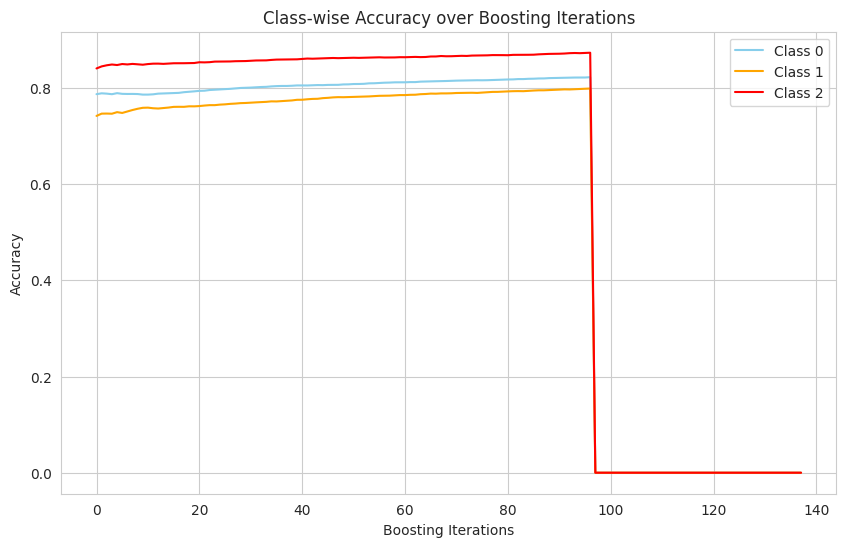

In [72]:
n_classes = len(np.unique(y_encoded))
class_accuracies = np.zeros((hgb_model.max_iter, n_classes))


for i, y_pred in enumerate(hgb_model.staged_predict(X_scaled)):
    for cls in range(n_classes):
        mask = y_encoded == cls
        class_accuracies[i, cls] = accuracy_score(y_encoded[mask], y_pred[mask])

plt.figure(figsize=(10, 6))
colors = ['skyblue', 'orange', 'red']
for cls in range(n_classes):
    plt.plot(class_accuracies[:, cls], label=f"Class {cls}", color=colors[cls])

plt.title("Class-wise Accuracy over Boosting Iterations")
plt.xlabel("Boosting Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [73]:
y_val_pred = hgb_model.predict(X_val_scaled)
accuracy_val = accuracy_score(y_val_encoded, y_val_pred)

print(f"Validation Accuracy: {accuracy_val:.4f}")
print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.8037
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2988
           1       0.73      0.77      0.75      2988
           2       0.81      0.83      0.82      2988

    accuracy                           0.80      8964
   macro avg       0.81      0.80      0.80      8964
weighted avg       0.81      0.80      0.80      8964



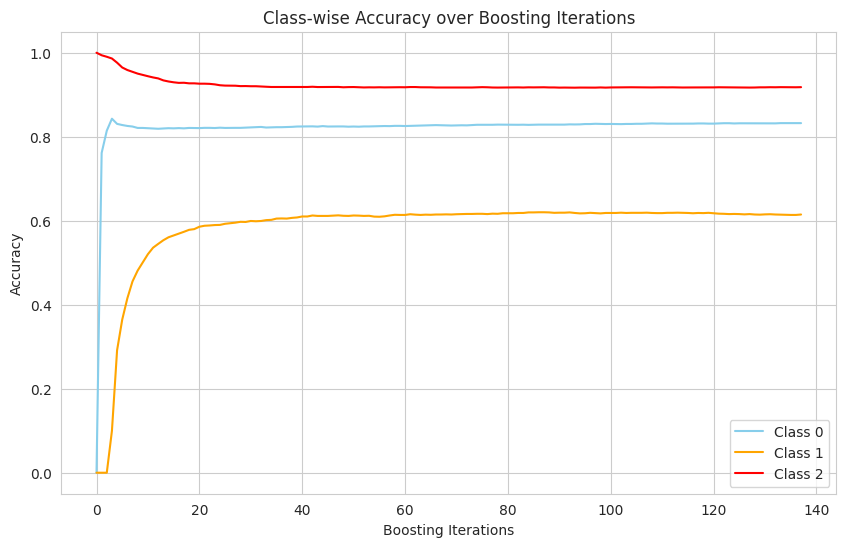

In [17]:
n_classes = len(np.unique(y_val_encoded))
class_accuracies = np.zeros((hgb_model.max_iter, n_classes))

for i, y_pred in enumerate(hgb_model.staged_predict(X_val_scaled)):
    for cls in range(n_classes):
        mask = y_val_encoded == cls
        class_accuracies[i, cls] = accuracy_score(y_val_encoded[mask], y_pred[mask])
 
colors = ['skyblue', 'orange', 'red']       
plt.figure(figsize=(10, 6))
for cls in range(n_classes):
    plt.plot(class_accuracies[:, cls], label=f"Class {cls}", color=colors[cls])
    
plt.title("Class-wise Accuracy over Boosting Iterations")
plt.xlabel("Boosting Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

<Axes: >

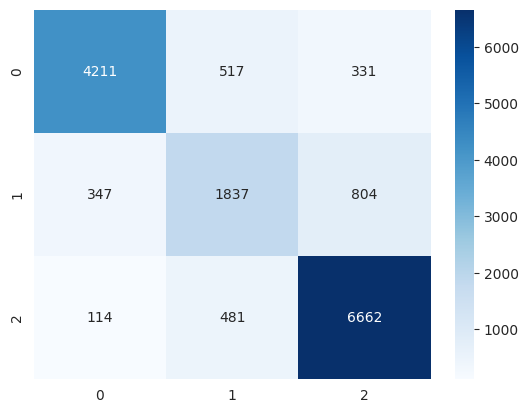

In [18]:
original_labels = label_encoder.inverse_transform(y_val_encoded)
pred_labels = label_encoder.inverse_transform(y_val_pred)

cm = confusion_matrix(original_labels, pred_labels)
colors = ['skyblue', 'orange', 'red']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [19]:
y_test_gbc = hgb_model.predict(X_test_scaled)
y_test_gbc = label_encoder.inverse_transform(y_test_gbc)

submission = pd.DataFrame(
    {'id': test_data["id"], 'Target': y_test_gbc},
    columns=['id', 'Target']
)
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


In [20]:
save_model(hgb_model, "hgboost")

Model saved as 'models/hgboost.pkl'


## Juan

In [21]:
train_data.describe(include='all')

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,...,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Graduate
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36282
mean,38258.500000,1.111934,16.054419,1.644410,9001.286377,0.915314,3.658760,132.378766,1.226600,19.837633,...,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921,NaN
std,22088.988286,0.441669,16.682337,1.229645,1803.438531,0.278416,8.623774,10.995328,3.392183,15.399456,...,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382,NaN
min,0.000000,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,NaN
25%,19129.250000,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,...,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000,NaN
50%,38258.500000,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,...,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000,NaN
75%,57387.750000,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,...,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000,NaN


In [22]:
train_data.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [23]:
train_data.dtypes

id                                                  int64
Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees u

In [24]:
train_data.isnull().any(axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
76513    False
76514    False
76515    False
76516    False
76517    False
Length: 76518, dtype: bool

### LightGBM


In [25]:
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'learning_rate': 0.06,
    'num_leaves': 20,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'class_weight': 'balanced',
    'seed': 42,
    'verbosity': -1
}

# Train the LightGBM model
lgb_model = LGBMClassifier(**params)
lgb_model.fit(X_scaled, y_encoded)

# Evaluate the model
y_train_pred = lgb_model.predict(X_scaled)
print(f"Train Accuracy: {accuracy_score(y_encoded, y_train_pred):.4f}")
print(classification_report(y_encoded, y_train_pred))

Train Accuracy: 0.8212
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     20237
           1       0.58      0.77      0.66     11952
           2       0.90      0.85      0.87     29025

    accuracy                           0.82     61214
   macro avg       0.80      0.81      0.80     61214
weighted avg       0.84      0.82      0.83     61214



In [26]:
y_val_pred = lgb_model.predict(X_val_scaled)
accuracy_val = accuracy_score(y_val_encoded, y_val_pred)
print(f"Validation Accuracy: {accuracy_val:.4f}")
print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.8127
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      5059
           1       0.56      0.76      0.65      2988
           2       0.90      0.84      0.87      7257

    accuracy                           0.81     15304
   macro avg       0.79      0.80      0.79     15304
weighted avg       0.84      0.81      0.82     15304



<Axes: >

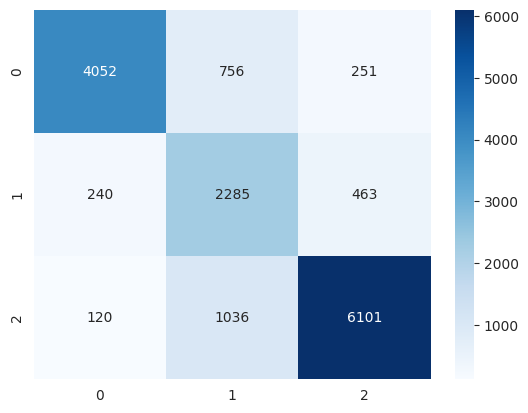

In [27]:
original_labels = label_encoder.inverse_transform(y_val_encoded)
pred_labels = label_encoder.inverse_transform(y_val_pred)

cm = confusion_matrix(original_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [28]:
def submitModel(model, X_test):
    Y_tilda = model.predict(X_test)
    y_decoded = label_encoder.inverse_transform(Y_tilda)
    submission = pd.DataFrame(
        {'id': test_data["id"], 'Target': y_decoded},
        columns = ['id', 'Target'])
    submission.to_csv('submission.csv', index = False)

In [29]:
submitModel(lgb_model, X_test_scaled)

In [30]:
save_model(lgb_model, "lgboost")

Model saved as 'models/lgboost.pkl'


## Fidan


In [31]:
dtrain = xgb.DMatrix(X_scaled, label=y_encoded)
dval = xgb.DMatrix(X_val_scaled, label=y_val_encoded)
dtest = xgb.DMatrix(X_test_scaled)

In [32]:
params = {
    "objective": "multi:softmax", 
    "num_class": len(np.unique(y_encoded)),
    "eval_metric": "mlogloss",
    "eta": 0.06,
    "max_depth": 8,
    "scale_pos_weight": {0: 1, 1: 2, 2: 1},
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.5,
}

In [33]:
num_boost_round = 200
early_stopping_rounds = 10
evals = [(dtrain, 'train'), (dval, 'eval')]

In [34]:
xgb_model = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=early_stopping_rounds)

[0]	train-mlogloss:1.04589	eval-mlogloss:1.04707
[1]	train-mlogloss:0.99875	eval-mlogloss:1.00110
[2]	train-mlogloss:0.95593	eval-mlogloss:0.95916
[3]	train-mlogloss:0.91771	eval-mlogloss:0.92201
[4]	train-mlogloss:0.88168	eval-mlogloss:0.88707
[5]	train-mlogloss:0.84883	eval-mlogloss:0.85510
[6]	train-mlogloss:0.81814	eval-mlogloss:0.82515
[7]	train-mlogloss:0.79031	eval-mlogloss:0.79829
[8]	train-mlogloss:0.76458	eval-mlogloss:0.77343
[9]	train-mlogloss:0.74079	eval-mlogloss:0.75029
[10]	train-mlogloss:0.71846	eval-mlogloss:0.72888
[11]	train-mlogloss:0.69807	eval-mlogloss:0.70930
[12]	train-mlogloss:0.67929	eval-mlogloss:0.69127
[13]	train-mlogloss:0.66217	eval-mlogloss:0.67503
[14]	train-mlogloss:0.64560	eval-mlogloss:0.65924
[15]	train-mlogloss:0.63008	eval-mlogloss:0.64452
[16]	train-mlogloss:0.61631	eval-mlogloss:0.63149
[17]	train-mlogloss:0.60390	eval-mlogloss:0.61997
[18]	train-mlogloss:0.59173	eval-mlogloss:0.60866
[19]	train-mlogloss:0.58023	eval-mlogloss:0.59780
[20]	train

In [35]:
y_pred_val = xgb_model.predict(dval)
accuracy = accuracy_score(y_val_encoded, y_pred_val)
print(f"Validation Accuracy: {accuracy:.4f}")
print(classification_report(y_val_encoded, y_pred_val))

Validation Accuracy: 0.8306
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      5059
           1       0.65      0.61      0.63      2988
           2       0.86      0.92      0.89      7257

    accuracy                           0.83     15304
   macro avg       0.80      0.79      0.79     15304
weighted avg       0.83      0.83      0.83     15304



<Axes: >

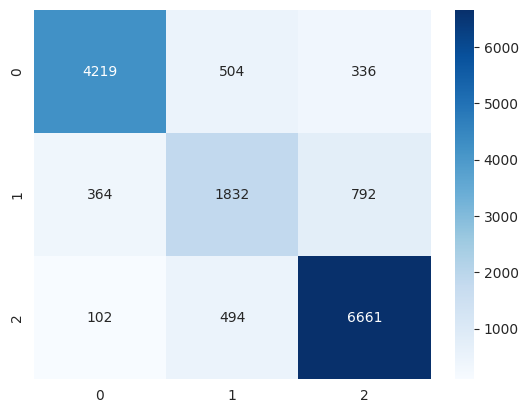

In [36]:
original_labels = label_encoder.inverse_transform(y_val_encoded)
pred_labels = label_encoder.inverse_transform(y_pred_val.astype(int))

cm = confusion_matrix(original_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [37]:
# Predict on test data
y_test_pred = xgb_model.predict(dtest)

predicted_labels = label_encoder.inverse_transform(y_test_pred.astype(int))

def submitModelPredictedLabels(predicted_labels, X_test):
    submission = pd.DataFrame(
        {'id': test_data["id"], 'Target': predicted_labels},
        columns=['id', 'Target']
    )
    submission.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")

In [38]:
submitModelPredictedLabels(predicted_labels, test_data)

Submission file saved as 'submission.csv'


In [39]:
save_model(xgb_model, "xgboost")

Model saved as 'models/xgboost.pkl'


# Ensemble model

In [40]:
ensemble_val = pd.DataFrame()
ensemble_val["model1"] = hgb_model.predict(X_val_scaled)
ensemble_val["model2"] = lgb_model.predict(X_val_scaled)
ensemble_val["model3"] = xgb_model.predict(dval)

ensemble_val['ensemble'] = ensemble_val[["model1", "model2", "model3"]].mode(axis=1)[0]
y_val_pred = ensemble_val['ensemble'].astype(int)

In [74]:
print(classification_report(y_val_encoded, y_val_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2988
           1       0.73      0.77      0.75      2988
           2       0.81      0.83      0.82      2988

    accuracy                           0.80      8964
   macro avg       0.81      0.80      0.80      8964
weighted avg       0.81      0.80      0.80      8964



<Axes: >

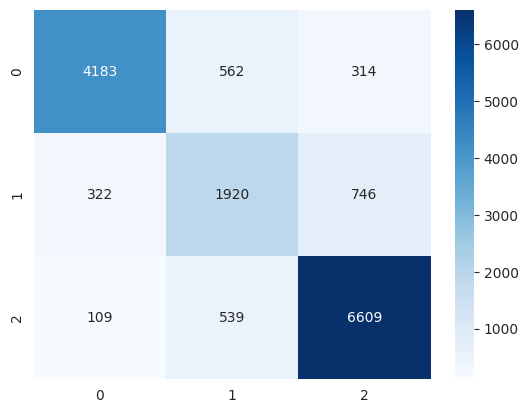

In [41]:
# Confussion matrix
cm = confusion_matrix(y_val_encoded, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

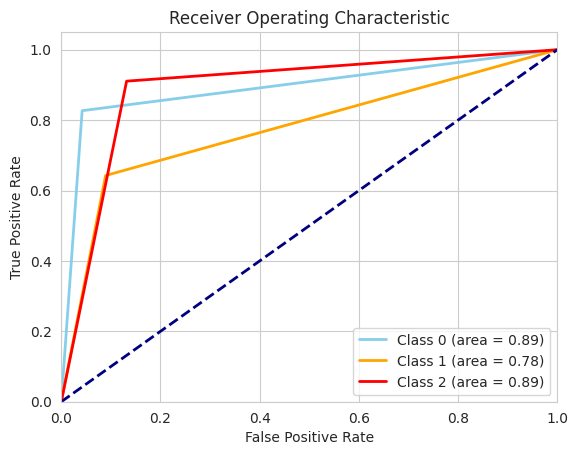

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define the colors
colors = ['skyblue', 'orange', 'red']

# Binarize the labels for ROC curve
y_val_binarized = label_binarize(y_val_encoded, classes=[0, 1, 2])
y_score = label_binarize(ensemble_val['ensemble'], classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})', color=colors[i])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

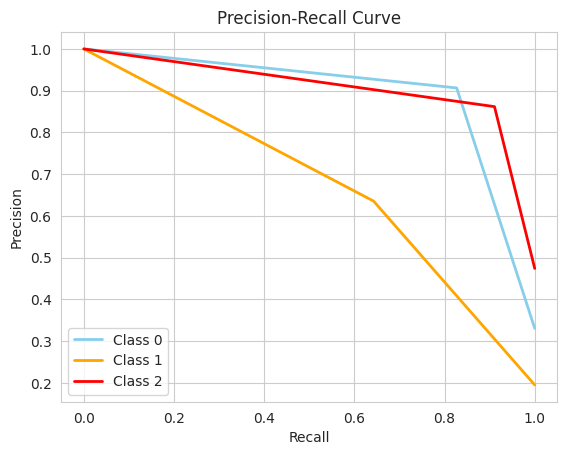

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Define the colors
colors = ['skyblue', 'orange', 'red']

# Binarize the labels for Precision-Recall curve
y_val_binarized = label_binarize(y_val_encoded, classes=[0, 1, 2])
y_score = label_binarize(ensemble_val['ensemble'], classes=[0, 1, 2])

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_score[:, i])

# Plot Precision-Recall curve for each class
plt.figure()
for i in range(3):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}', color=colors[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

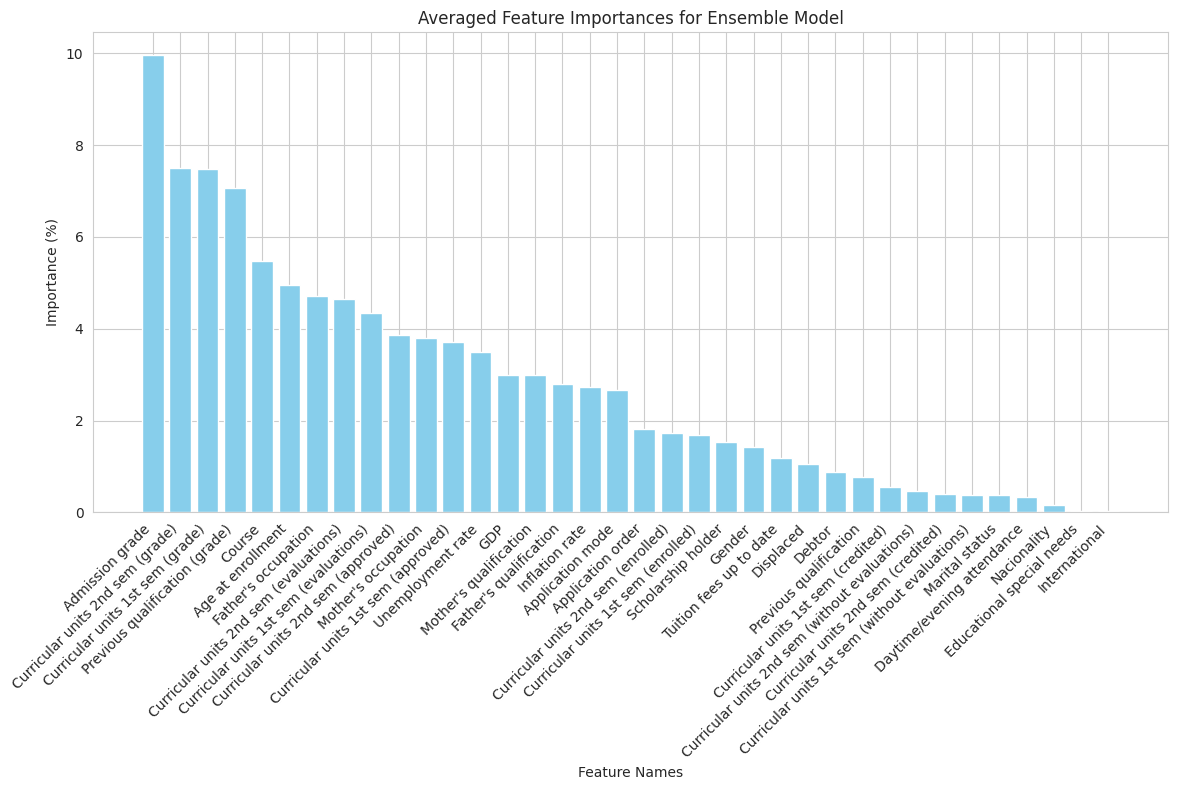

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# feature names
feature_names = X.columns

# 1. Calculate permutation importance for HistGradientBoostingClassifier
hgb_importance_result = permutation_importance(hgb_model, X_scaled, y_train, n_repeats=10, random_state=42)
hgb_importances = hgb_importance_result.importances_mean

# 2. Extract feature importances from LightGBM and XGBoost
lgb_importances = lgb_model.feature_importances_
xgb_importances = xgb_model.get_score(importance_type='weight')

# 3. Convert XGBoost importances to an array
xgb_importances_array = np.zeros(len(feature_names))
for feature, importance in xgb_importances.items():
    xgb_importances_array[int(feature[1:])] = importance

# 4. Calculate the average feature importances
average_importances = (hgb_importances + lgb_importances + xgb_importances_array) / 3

# 5. Normalize importances to percentages
average_importances_percent = (average_importances / average_importances.sum()) * 100

# 6. Sort features by importance
sorted_indices = np.argsort(average_importances_percent)[::-1]
sorted_importances = average_importances_percent[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# 7. Plot the sorted feature importances as percentages
plt.figure(figsize=(12, 8))
plt.bar(sorted_feature_names, sorted_importances, color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Feature Names')
plt.ylabel('Importance (%)')
plt.title('Averaged Feature Importances for Ensemble Model')
plt.tight_layout()
plt.show()

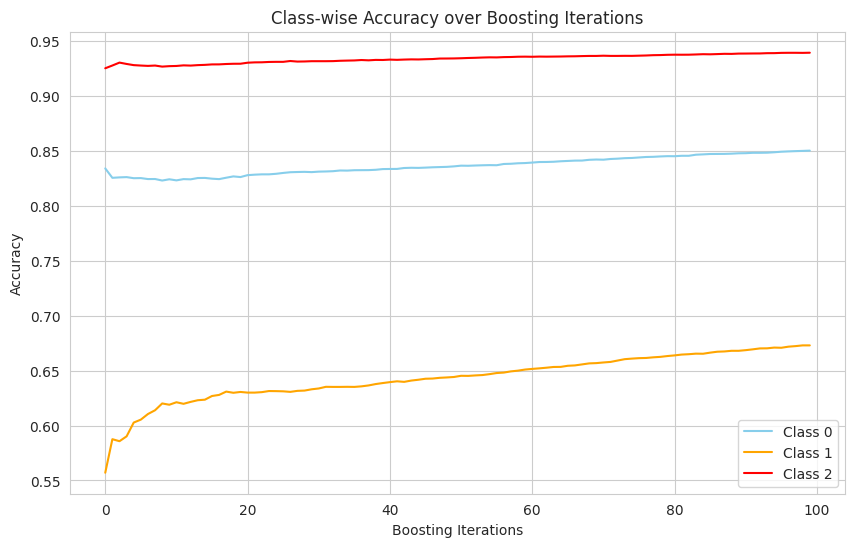

In [65]:
n_classes = len(np.unique(y_encoded))
n_iterations = min(hgb_model.max_iter, lgb_model.n_estimators, xgb_model.best_iteration)
class_accuracies = np.zeros((n_iterations, n_classes))

for i in range(n_iterations):
    y_pred_hgb = hgb_model.staged_predict(X_scaled).__next__()
    y_pred_lgb = lgb_model.predict(X_scaled, num_iteration=i+1)
    y_pred_xgb = xgb_model.predict(dtrain, iteration_range=(0, i+1))

    y_pred_ensemble = np.array([np.bincount([y_pred_hgb[j], y_pred_lgb[j], y_pred_xgb[j]]).argmax() for j in range(len(y_pred_hgb))])

    for cls in range(n_classes):
        mask = y_encoded == cls
        class_accuracies[i, cls] = accuracy_score(y_encoded[mask], y_pred_ensemble[mask])

plt.figure(figsize=(10, 6))
colors = ['skyblue', 'orange', 'red']
for cls in range(n_classes):
    plt.plot(class_accuracies[:, cls], label=f"Class {cls}", color=colors[cls])

plt.title("Class-wise Accuracy over Boosting Iterations")
plt.xlabel("Boosting Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
ensemble = pd.DataFrame()
ensemble["model1"] = hgb_model.predict(X_test_scaled)
ensemble["model2"] = lgb_model.predict(X_test_scaled)
ensemble["model3"] = xgb_model.predict(dtest)

In [42]:
ensemble['ensemble'] = ensemble[["model1", "model2", "model3"]].mode(axis=1)[0]
ensemble['ensemble'] = ensemble['ensemble'].astype(int)
# decode the obtained labels
ensemble['ensemble'] = label_encoder.inverse_transform(ensemble['ensemble'])
print(ensemble['ensemble'].head())

0     Dropout
1    Graduate
2    Graduate
3    Enrolled
4    Enrolled
Name: ensemble, dtype: object


In [43]:
def submitModelPredictedLabels(predicted_labels):
    submission = pd.DataFrame(
        {'id': test_data["id"], 'Target': predicted_labels},
        columns=['id', 'Target']
    )
    submission.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")

In [44]:
submitModelPredictedLabels(ensemble['ensemble'])

Submission file saved as 'submission.csv'
